In [1]:
%pylab inline
import numpy as np
import tensorflow as tf
from queue import deque

from tools import create_sin, make_timeseries, split_train_test, visualize_random_data
from tools import batch_loader, shuffle

from pprint import pprint as pp

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Data

train_x: (5232, 64, 1)
train_y: (5232, 64, 1)
test_x : (1308, 64, 1)
test_y : (1308, 64, 1)


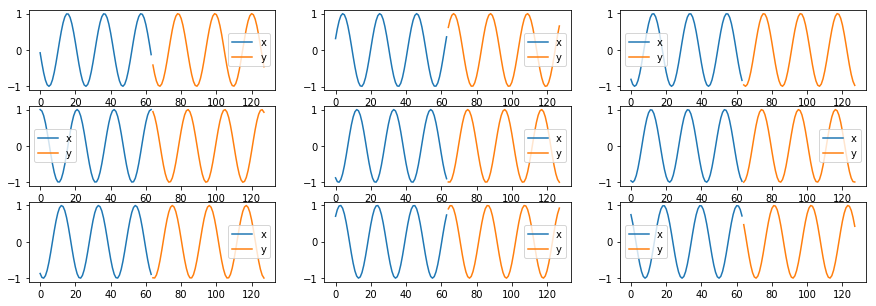

In [2]:
X_SIZE = 64
Y_SIZE = 64

data = create_sin()
data_x, data_y = make_timeseries(data, x_size=X_SIZE, y_size=Y_SIZE)
train_x, test_x = split_train_test(data_x)
train_y, test_y = split_train_test(data_y)

print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x :', test_x.shape)
print('test_y :', test_y.shape)

visualize_random_data(train_x, train_y)

# Model

In [3]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1, allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options,
                                                   log_device_placement=True))

In [4]:
X_TIME_SIZE = 64
Y_TIME_SIZE = 64
FEATURE_SIZE = 1
HIDDEN_SIZE = 32
RNN_OUTPUT_SIZE = 16


np.random.seed(0)
rnn_input = tf.placeholder(tf.float64, shape=(None, X_TIME_SIZE, FEATURE_SIZE))
rnn_output = tf.placeholder(tf.float64, shape=(None, X_TIME_SIZE, FEATURE_SIZE))
init_state = tf.placeholder(tf.float64, shape=(None, HIDDEN_SIZE))

# Simple RNN
Wxh = tf.get_variable('Wxh', shape=(FEATURE_SIZE, HIDDEN_SIZE),
                      initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float64) 
Whh = tf.get_variable('Whh', shape=(HIDDEN_SIZE, HIDDEN_SIZE), 
                      initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float64) 
Why = tf.get_variable('Why', shape=(HIDDEN_SIZE, RNN_OUTPUT_SIZE), 
                      initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float64) 
bh = tf.get_variable('bh', shape=(1, HIDDEN_SIZE), 
                      initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float64) 
by = tf.get_variable('by', shape=(FEATURE_SIZE, 1), 
                      initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float64) 

# Output layer
linear_w = tf.get_variable('linear_w', shape=(RNN_OUTPUT_SIZE, FEATURE_SIZE), 
                      initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float64) 
linear_b = tf.get_variable('linear_b', shape=(FEATURE_SIZE), 
                      initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float64) 



y_preds = list()
losses = list()
hiddens = np.zeros(X_TIME_SIZE+1, dtype=np.object)
hiddens[-1] = init_state

unstacked_inputs = tf.unstack(rnn_input, axis=1)
unstacked_outputs = tf.unstack(rnn_output, axis=1)

for t, (input_t, y_true) in enumerate(zip(unstacked_inputs, unstacked_outputs)):
    hidden = tf.tanh(tf.matmul(input_t, Wxh) + tf.matmul(hiddens[t-1], Whh) + bh)
    y_pred = tf.matmul(hidden, Why) + by
    y_pred = tf.nn.tanh(y_pred)
    
    # Linear
    y_pred = tf.matmul(y_pred, linear_w) + linear_b
    
    loss = tf.losses.mean_squared_error(y_true, y_pred)
    
    hiddens[t] = hidden
    y_preds.append(y_pred)
    losses.append(loss)

total_loss = tf.reduce_mean(losses)
train = tf.train.AdamOptimizer().minimize(total_loss)
sess.run(tf.global_variables_initializer())

# TensorBoard
train_writer = tf.summary.FileWriter('./tfboard-log', sess.graph)

# Train

In [5]:
for epoch in range(100):
    train_x, train_y = shuffle(train_x, train_y)
    for sample_x, sample_y in batch_loader(train_x, train_y, batch_size=2048):
        state = np.zeros((sample_x.shape[0], HIDDEN_SIZE))
        _total_loss, _ = sess.run([total_loss, train], 
                                       feed_dict={rnn_input: sample_x, 
                                                  rnn_output: sample_y,
                                                  init_state: state})
        print(f'[Epoch:{epoch+1}] loss: {_total_loss:<7.4}', end='\r')
    print()

[Epoch:1] loss: 1.511  
[Epoch:2] loss: 1.28   
[Epoch:3] loss: 1.074  
[Epoch:4] loss: 0.8876 
[Epoch:5] loss: 0.7107 
[Epoch:6] loss: 0.5805 
[Epoch:7] loss: 0.5041 
[Epoch:8] loss: 0.4576 
[Epoch:9] loss: 0.4255 
[Epoch:10] loss: 0.3922 
[Epoch:11] loss: 0.3533 
[Epoch:12] loss: 0.32   
[Epoch:13] loss: 0.2939 
[Epoch:14] loss: 0.2705 
[Epoch:15] loss: 0.2416 
[Epoch:16] loss: 0.2133 
[Epoch:17] loss: 0.1899 
[Epoch:18] loss: 0.1655 
[Epoch:19] loss: 0.1413 
[Epoch:20] loss: 0.118  
[Epoch:21] loss: 0.09657
[Epoch:22] loss: 0.07696
[Epoch:23] loss: 0.05812
[Epoch:24] loss: 0.04585
[Epoch:25] loss: 0.03664
[Epoch:26] loss: 0.03157
[Epoch:27] loss: 0.02926
[Epoch:28] loss: 0.02742
[Epoch:29] loss: 0.02704
[Epoch:30] loss: 0.02474
[Epoch:31] loss: 0.02288
[Epoch:32] loss: 0.02174
[Epoch:33] loss: 0.01999
[Epoch:34] loss: 0.01938
[Epoch:35] loss: 0.0189 
[Epoch:36] loss: 0.01834
[Epoch:37] loss: 0.01792
[Epoch:38] loss: 0.01785
[Epoch:39] loss: 0.01751
[Epoch:40] loss: 0.01715
[Epoch:41

# Evaluate

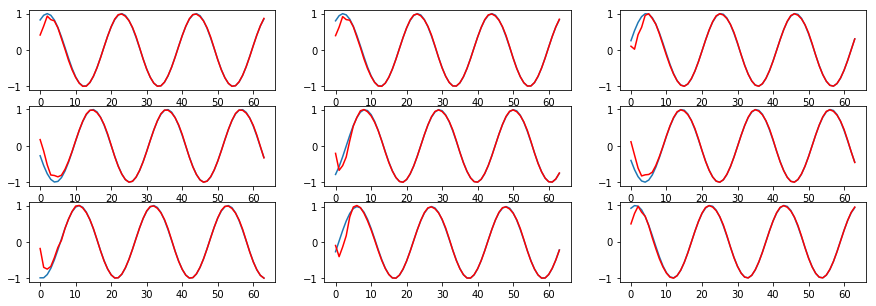

In [9]:
N = test_x.shape[0]
idices = np.random.choice(np.arange(N), size=9, replace=False)

result_pred = []
result_true = []

for idx in idices:
    sample_x = test_x[idx:idx+1]
    sample_y = test_y[idx:idx+1]
    state = np.zeros((sample_x.shape[0], HIDDEN_SIZE))
    _total_loss, _y_preds = sess.run([total_loss, y_preds], 
                                     feed_dict={rnn_input: sample_x, 
                                                rnn_output: sample_y,
                                                init_state: state})
    _y_preds = np.array(_y_preds).reshape(-1, 1)
    result_pred.append(_y_preds)
    result_true.append(sample_y.reshape(-1, 1))

fig, plots = plt.subplots(3, 3)
fig.set_figheight(5)
fig.set_figwidth(15)

plots = plots.reshape(-1)
for i, p in enumerate(plots):
    p.plot(result_true[i])
    p.plot(result_pred[i], color='red')